# Detect tunnels in the environment

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [53]:

start_locs = np.array([[5,1],[-5,-1]])
goal_locs = np.array([[-5,1],[5,-1]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-5.0,-0.5),(0.5,10))
O2 = Box2DRegion((-0.0,5.0),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

In [59]:
import shapely
from shapely.ops import nearest_points
from shapely.affinity import translate,rotate

In [85]:
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely import Polygon,LineString,Point

import cvxpy as cp

In [107]:

def extension_sticks(O1,O2,ext_l):
    pts = nearest_points(O2.vertices(),O1.vertices())

    neck = LineString(pts)
    perp = rotate(neck,90)

    direction = np.array(perp.coords[:])
    direction = direction[1]-direction[0]

    direction /= np.linalg.norm(direction)

    shifted_neck = translate(neck, *ext_l*direction)

    shift_origin = np.mean(shifted_neck.coords,axis= 0)

    projs = []
    dists = []
    for O in [O1,O2]:
        A,b = O.A,O.b

        x_proj = cp.Variable(shift_origin.shape)
        constraints = [(x_proj - shift_origin) @ direction ==0,
                      A @ x_proj<=b]
        prob = cp.Problem(cp.Minimize(cp.norm(x_proj-shift_origin)),constraints)

        dist = prob.solve()

        if dist is None:
            projs.append(None)
            dists.append(None)
        else:
            projs.append(x_proj.value)
            dists.append(dist)
    return projs, dists

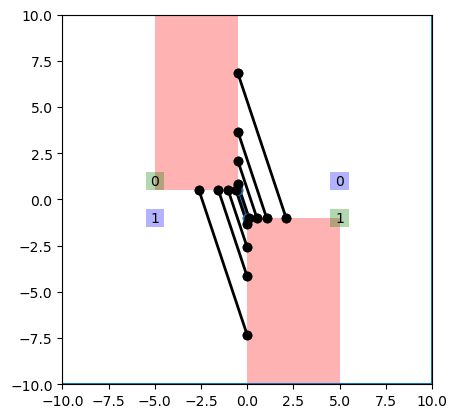

In [112]:
ax = plt.gca()

draw_env(env,ax=ax)
plot_points(pts,ax=ax)
plot_line(neck,ax=ax)
for ext_l in [0.1,0.5,1.0,2.0,-0.1,-0.5,-1.0,-2.0]:
    projs,dists = extension_sticks(O1,O2,ext_l) 
    plot_points([Point(p) for p in projs],ax=ax, color = 'black')
    plot_line(LineString([Point(p) for p in projs]),ax=ax, color = 'black')